In [22]:
import numpy as np
import pandas as pd
import os
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
!pip install sentence-transformers faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [24]:
import faiss
from textblob import TextBlob
from sentence_transformers import SentenceTransformer

In [25]:
model = SentenceTransformer('msmarco-distilbert-base-dot-prod-v3')
# data = pd.read_csv('./data/wiki_movie_plots_deduped.csv')

# Comment the following lines for local execution
from google.colab import drive
drive.mount('/content/gdrive')


# data = data.iloc[:5000]
# data.info()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [15]:
# Comment this block for local execution

data = pd.read_csv('/content/gdrive/My Drive/Projects/NLP Project/wiki_movie_plots_deduped.csv')
data = data.iloc[:5000]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      5000 non-null   int64 
 1   Title             5000 non-null   object
 2   Origin/Ethnicity  5000 non-null   object
 3   Director          5000 non-null   object
 4   Cast              4895 non-null   object
 5   Genre             5000 non-null   object
 6   Wiki Page         5000 non-null   object
 7   Plot              5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB


/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histogr

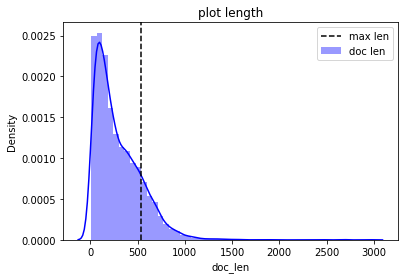

In [16]:
data = data[['Title', 'Plot']]
data.dropna(inplace=True)
data.drop_duplicates(subset=['Plot'], inplace=True)

data['doc_len'] = data['Plot'].apply(lambda words: len(words.split()))
max_seq_len = np.round(data['doc_len'].mean() + data['doc_len'].std()).astype(int)
sns.distplot(data['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

In [26]:
encoded_data = model.encode(data.Plot.tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(data))))
faiss.write_index(index, 'movie_plot.index')

In [27]:
def fetch_movie_info(dataframe_idx):
    info = data.iloc[dataframe_idx]
    meta_dict = {}
    meta_dict['Title'] = info['Title']
    return meta_dict
    
def search(query, top_k, index, model):
    t=time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, top_k)
    print('>>>> Results in Total Time: {}'.format(time.time()-t))
    top_k_ids = top_k[1].tolist()[0]
    top_k_ids = list(np.unique(top_k_ids))
    results =  [fetch_movie_info(idx) for idx in top_k_ids]
    return results

In [28]:
from pprint import pprint

query="Artificial Intelligence based action movie"
results=search(query, top_k=3, index=index, model=model)

print("\n")
for result in results:
    print('\t',result)

>>>> Results in Total Time: 0.01651477813720703


	 {'Title': 'Mr. Robinson Crusoe'}
	 {'Title': "Hellzapoppin'"}
	 {'Title': 'Jigsaw'}
